# Libraries

In [1]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Display functions

In [2]:
def display_instance(df_ports):
    # Créer une nouvelle figure
    plt.figure(figsize=(10, 8))

    # Créer une carte centrée sur une certaine position
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Déterminer les limites des coordonnées des ports
    min_lon, max_lon = df_ports['longitude'].min(), df_ports['longitude'].max()
    min_lat, max_lat = df_ports['latitude'].min(), df_ports['latitude'].max()


    # Calculer la marge en pourcentage
    margin_lon = (max_lon - min_lon) * 0.2
    margin_lat = (max_lat - min_lat) * 0.2

    # Ajouter la marge aux limites des coordonnées
    min_lon -= margin_lon
    max_lon += margin_lon
    min_lat -= margin_lat
    max_lat += margin_lat

    # Ajuster l'étendue de la carte pour encadrer les ports
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])

    # Ajouter un fond de carte
    ax.stock_img()
    res = '50m' # 10, 50 ou 110

    ax.coastlines(resolution=res, color='black')
    # ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='blue');

    # Ajouter les marqueurs pour chaque port
    for index, port in df_ports.iterrows():
        lat, lon = port['latitude'], port['longitude']
        if index == 0 :
            plt.plot(lon, lat, marker = 'o', markersize=5, color = 'red')  # Utilisation de marqueurs bleus pour les ports
            plt.text(lon, lat, port['port_code'], fontsize=12, ha='right')
        else :
            plt.plot(lon, lat, 'bo', markersize=4)  # Utilisation de marqueurs bleus pour les ports
            plt.text(lon, lat, port['port_code'], fontsize=10, ha='right')

    # Afficher la carte
    plt.show()

In [3]:
def display_solution(df_ports, x):
    # Créer une nouvelle figure
    plt.figure(figsize=(10, 8))

    # Créer une carte centrée sur une certaine position
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Déterminer les limites des coordonnées des ports
    min_lon, max_lon = df_ports['longitude'].min(), df_ports['longitude'].max()
    min_lat, max_lat = df_ports['latitude'].min(), df_ports['latitude'].max()


    # Calculer la marge en pourcentage
    margin_lon = (max_lon - min_lon) * 0.2
    margin_lat = (max_lat - min_lat) * 0.2

    # Ajouter la marge aux limites des coordonnées
    min_lon -= margin_lon
    max_lon += margin_lon
    min_lat -= margin_lat
    max_lat += margin_lat

    # Ajuster l'étendue de la carte pour encadrer les ports
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])

    # Ajouter un fond de carte

    ax.stock_img()
    res = '50m'

    ax.coastlines(resolution=res, color='black')
    # ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='blue');

    # Ajouter marqueur pour le hub
    port = df_ports.loc[0]
    lat, lon = port['latitude'], port['longitude']
    plt.plot(lon, lat, marker = 'o', markersize=5, color = 'black') 
    plt.text(lon, lat, port['port_code'], fontsize=10, ha='right')

    # Assignation couleurs aux navires
    # Ajouter plus de couleurs si + de 10 navires 
    l_colors = ['blue', 'red', 'green', 'yellow', 'cyan', 'magenta', 'purple', 'orange', 'brown', 'pink']
    colors = {}
    index_color = 0
    for k in K:
        colors[k] = l_colors[index_color]
        index_color += 1

    # Tracé des routes
    for k in K:
        legend_ok = False
        for i, port_i in df_ports.iterrows():
            for j, port_j in df_ports.iterrows():
                if x[k][i][j].varValue :

                    # Calculer la direction de la flèche
                    dx = port_j['longitude'] - port_i['longitude']
                    dy = port_j['latitude'] - port_i['latitude']
                    length = np.sqrt(dx**2 + dy**2)

                    # Nouvelles coordonnées pour le point d'arrivée
                    new_port_j_longitude = port_j['longitude'] - dx*1.5/(length)
                    new_port_j_latitude = port_j['latitude'] - dy*1.5/(length)

                    # Tracer la flèche
                    if legend_ok :
                        plt.arrow(port_i['longitude'], port_i['latitude'], new_port_j_longitude-port_i['longitude'], new_port_j_latitude-port_i['latitude'], head_width=0.5, head_length=1, fc=colors[k], ec=colors[k])
                    else : 
                        plt.arrow(port_i['longitude'], port_i['latitude'], new_port_j_longitude-port_i['longitude'], new_port_j_latitude-port_i['latitude'], head_width=0.5, head_length=1, fc=colors[k], ec=colors[k], label=f'Navire {k}')
                        legend_ok = True

                    #Tracer point pour le port
                    if i!= 0 :
                        plt.plot(port_i['longitude'], port_i['latitude'],  marker = 'o', markersize=4, color = colors[k])  # Utilisation de marqueurs bleus pour les ports
                        plt.text(port_i['longitude'], port_i['latitude'], port_i['port_code'], fontsize=10, ha='right')
    
    # Légende
    plt.legend()

    
    # Afficher la carte
    plt.show()

# Auxiliary function

In [4]:
# Prend en entrée les dataframe contenant les données du fichier d'instance
# Renvoie les données du modèle maths 

def get_model_data(df_ports, df_vessels, df_arcs):
    ################ Ensembles
    P = range(len(df_ports)) # ensemble des sommets du graphe (hub + ports à desservir) 
    P_0 = range(1,len(df_ports)) # ensemble des ports de feedering (P sans le port 0 correspondant au hub)
    K = list(df_vessels['id']) # ensemble de navires

    ################ Demandes
    d_in = df_ports['d_in'] # demandes import pour chaque port de P
    d_out = df_ports ['d_out'] # demandes export pour chaque port de P

    ################ Couts et durées des arcs
    c = {}
    t = {}
    for _, row in df_arcs.iterrows():
        k = row['vessel']
        if k not in c:
            c[k] = {}
            t[k] = {}
        i, j = row['port_i'], row['port_j']
        if i not in c[k]:
            c[k][i] = {}
            t[k][i] = {}
        c[k][i][j], t[k][i][j] = row['cost'], row['duration']

    ################ Capacité des navires
    q = {}
    for _, row in df_vessels.iterrows():
        q[row['id']] = row['capacity']

    ################ Big M
    M = sum(d_in)

    return P, P_0, K, d_in, d_out, c, t, q, M

In [5]:
# Fonction auxiliaire pour itérer sur les sous ensembles de taille supérieure à 2 de l'ensemble [1, 2, 3 ..., N-1]
def iterate_subsets(N):
    subsets = []
    for mask in range(1, 1 << N):  # Commencer à 1 pour exclure le cas où le masque est 0
        subset = [i for i in range(N) if mask & (1 << i)]
        if 0 not in subset and len(subset) >= 2:  # Vérifier si le sous-ensemble ne contient pas zéro et a une taille supérieure ou égale à 2
            subsets.append(subset)
    return subsets

# Import data instance from excel file

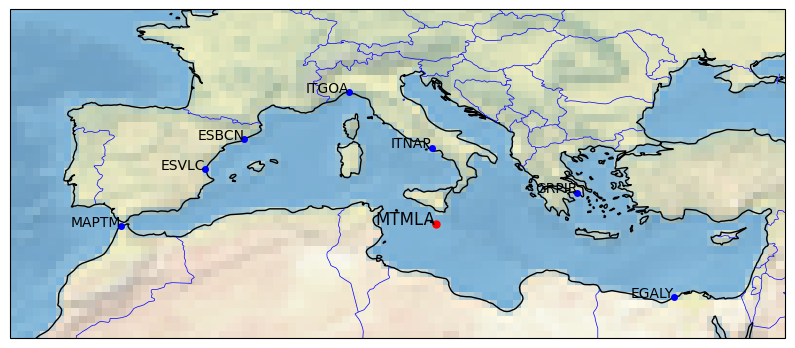

In [6]:
file_name = 'Instance 1.1 - Malta.xlsx'
# file_name = 'Instance 1.2 - Malta.xlsx'
# file_name = 'Instance 2 - Kingston.xlsx'

df_ports = pd.read_excel(file_name, sheet_name='ports')
display_instance(df_ports)

In [7]:
df_vessels = pd.read_excel(file_name, sheet_name='vessels')
df_vessels

,id,capacity
0,1,400
1,2,500
2,3,500


In [8]:
df_arcs = pd.read_excel(file_name, sheet_name='arcs')
df_arcs

,vessel,port_i,port_j,cost,duration
0,1,0,0,0,0
1,2,0,0,0,0
2,3,0,0,0,0
3,1,0,1,1057,4
4,2,0,1,1268,4
...,...,...,...,...,...
187,2,7,6,1131,3
188,3,7,6,943,3
189,1,7,7,0,0
190,2,7,7,0,0


# Model data definition

In [9]:
P, P_0, K, d_in, d_out, c, t, q, M = get_model_data(df_ports, df_vessels, df_arcs)
t_max = 14 # Durée maximale d'une rotation

print("Données du problème :")
print(f"  -> Hub : {df_ports['port_code'][0]}")
print(f"  -> Nombre de ports à desservir : {len(P_0)}")
print(f"  -> Nombre de navires : {len(K)}")
print(f"  -> Durée maximale des rotations : {t_max} jours")

Données du problème :
  -> Hub : MTMLA
  -> Nombre de ports à desservir : 7
  -> Nombre de navires : 3
  -> Durée maximale des rotations : 14 jours


# Problem implementation & resolution

### Problem initialisation

In [10]:
prob = LpProblem("Feedering_Network", LpMinimize)  # Ou LpMaximize pour un problème de maximisation

### Decision variables

In [11]:
x = LpVariable.dicts("x", (K, P, P), cat='Binary')
L0 = LpVariable.dicts("L0", (K), lowBound=0, cat='Continuous')
L = LpVariable.dicts("L",P_0, lowBound=0, cat='Continuous')

### Objective function

In [12]:
prob += sum([c[k][i][j] * x[k][i][j] for k in K for i in P for j in P])

### Constraints

In [13]:
################## Contraintes sur la structure des cycles ##################

# Diagonale nulle
for i in P:
  for k in K:
    prob += x[k][i][i] == 0

# Chaque navire part du hub une fois
for k in K:
  prob += sum(x[k][0][j] for j in P) == 1


# Chaque navire rentre au hub une fois
for k in K:
  prob += sum(x[k][j][0] for j in P) == 1


# Si un navire rentre dans un port, il en ressort
for k in K:
  for i in P:
    prob += sum(x[k][j][i] for j in P) == sum(x[k][i][j] for j in P)



# Elimination des sous tours
for S in iterate_subsets(len(P)):
    for k in K:
      prob += sum(x[k][i][j] for i in S for j in S) <= len(S) - 1

################## Contrainte pour assurer que la demande est satisfaite ##################

# Chaque port est visité, et ce par un unique navire
for i in P_0:
  prob += sum((sum(x[k][i][j] for k in K)) for j in P) == 1



################## Contraintes relatives à la capacité des navires ##################

# Le navire K part du hub avec à bord la somme des demandes in à desservir
for k in K:
  prob += L0[k] == sum(d_in[j]*x[k][i][j] for i in P for j in P)


# Cohérence des valeurs de L0 et L_j
for k in K:
  for j in P_0:
    prob += (1-x[k][0][j])*M + L[j] >= L0[k] - d_in[j] + d_out[j]


# Cohérence des valeurs des L_j
for j in P_0:
  prob += L[j] <= sum((sum(q[k]*x[k][i][j] for k in K)) for i in P)


# Le navire a assez de capacités pr desservir toutes les demandes in de sa rotation
for k in K:
  prob += L0[k] <= q[k]


# La capacité du navire est respecté à la sortie de chaque port
for k in K:
  for j in P_0:
    for i in P_0:
      prob += (1-x[k][i][j])*M + L[j] >= L[i] - d_in[j] + d_out[j]


################## Contrainte liée à la durée totale des rotations ##################
for k in K:
  prob += sum(t[k][i][j]*x[k][i][j] for i in P for j in P) <= t_max



### Problem resolution

In [14]:
t0 = time()
prob.solve()
t_exec = time() - t0

# Affichage du statut de la résolution
print("Statut de la résolution :", LpStatus[prob.status])

# Affichage de la solution optimale
print("Valeur optimale de la fonction objectif :", value(prob.objective))

# Affichage temps execution
print(f"Durée de la résolution : {round(t_exec,2)}s")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/816b0c0db6e9456e91c5343137f2209b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/816b0c0db6e9456e91c5343137f2209b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 610 COLUMNS
At line 8118 RHS
At line 8724 BOUNDS
At line 8917 ENDATA
Problem MODEL has 605 rows, 202 columns and 6910 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8602 - 0.00 seconds
Cgl0002I 24 variables fixed
Cgl0003I 17 fixed, 0 tightened bounds, 182 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 96 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 166 strengthened rows, 0 substitutions
Cgl00

In [15]:
# Affichage des variables
for k in K:
    for i in P:
        for j in P:
            print(f"x[{k}][{i}][{j}] = {x[k][i][j].varValue}")

x[1][0][0] = 0.0
x[1][0][1] = 0.0
x[1][0][2] = 0.0
x[1][0][3] = 0.0
x[1][0][4] = 0.0
x[1][0][5] = 0.0
x[1][0][6] = 1.0
x[1][0][7] = 0.0
x[1][1][0] = 0.0
x[1][1][1] = 0.0
x[1][1][2] = 0.0
x[1][1][3] = 0.0
x[1][1][4] = 0.0
x[1][1][5] = 0.0
x[1][1][6] = 0.0
x[1][1][7] = 0.0
x[1][2][0] = 0.0
x[1][2][1] = 0.0
x[1][2][2] = 0.0
x[1][2][3] = 0.0
x[1][2][4] = 0.0
x[1][2][5] = 0.0
x[1][2][6] = 0.0
x[1][2][7] = 0.0
x[1][3][0] = 0.0
x[1][3][1] = 0.0
x[1][3][2] = 0.0
x[1][3][3] = 0.0
x[1][3][4] = 0.0
x[1][3][5] = 0.0
x[1][3][6] = 0.0
x[1][3][7] = 0.0
x[1][4][0] = 0.0
x[1][4][1] = 0.0
x[1][4][2] = 0.0
x[1][4][3] = 0.0
x[1][4][4] = 0.0
x[1][4][5] = 0.0
x[1][4][6] = 0.0
x[1][4][7] = 0.0
x[1][5][0] = 0.0
x[1][5][1] = 0.0
x[1][5][2] = 0.0
x[1][5][3] = 0.0
x[1][5][4] = 0.0
x[1][5][5] = 0.0
x[1][5][6] = 0.0
x[1][5][7] = 0.0
x[1][6][0] = 0.0
x[1][6][1] = 0.0
x[1][6][2] = 0.0
x[1][6][3] = 0.0
x[1][6][4] = 0.0
x[1][6][5] = 0.0
x[1][6][6] = 0.0
x[1][6][7] = 1.0
x[1][7][0] = 1.0
x[1][7][1] = 0.0
x[1][7][2] = 0

### Display solution

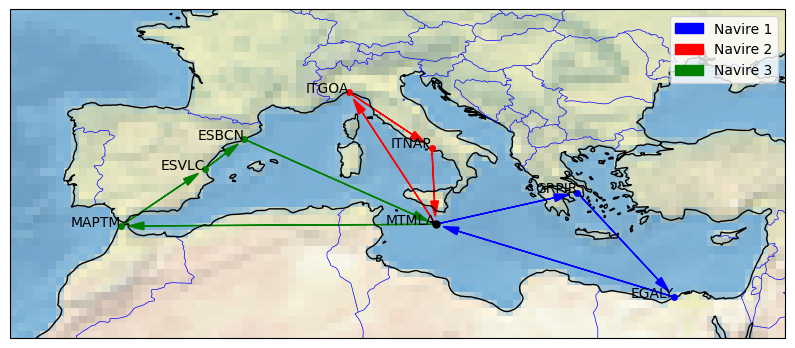

Charge initiale des navires au départ de MTMLA :
     -> Navire 1 : 300.0 TEU
     -> Navire 2 : 250.0 TEU
     -> Navire 3 : 250.0 TEU

Temps totale des rotations de chaque navire :
     -> Navire 1 : 13.0 jours
     -> Navire 2 : 8.0 jours
     -> Navire 3 : 14.0 jours


In [16]:
display_solution(df_ports, x)

print(f"Charge initiale des navires au départ de {df_ports['port_code'][0]} :")   
for k in K:
    print(f'     -> Navire {k} : {L0[k].varValue} TEU')
    
print(f"\nTemps totale des rotations de chaque navire :")  
for k in K:
    print(f'     -> Navire {k} : {sum([t[k][i][j] * x[k][i][j].varValue for i in P for j in P])} jours')
